In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

import arviz as az

In [2]:
az.style.use('arviz-white')

# Metropolis + Gibbs sampling for simulated data

Here we use simulate data to verify that the code is working properly.  We generate a synthetic dataset and run MCMC to estimate the parameters.  Unlike a real data analysis, for a simulation study we know the true values of the parameters and so this provides a check that the code is functioning well.

The data are generated from the logistic regression model $$Y_i\sim\mbox{Bernoulli}(p_i) \mbox{  where  } p_i = \frac{1}{1+\exp(-\sum_{j=1}^pX_{ij}\beta_j)}.$$
The covariates are generated as $X_{i1}=1$ for the intercept and $X_{ij}\sim\mbox{Normal}(0,1)$ for $j>1$.  The true values of $\beta_j$ are also sampled from a normal distribution.

We fit the model with prior $\beta_j\sim\mbox{Normal}(0,\sigma^2)$ and $\sigma^2\sim\mbox{Gamma}(a,b)$.  The MCMC code using Metropolis steps to update the $\beta_j$ and a Gibbs step to update $\sigma^2$.


## Simulate data

In [3]:
n = 100
p = 20
X = np.ones((n, p))
X[:,1:] = stats.norm().rvs((n, p-1))
true_beta = stats.norm(0, .5).rvs(p)
prob = 1/(1+np.exp(-X @ true_beta))
Y = stats.binom(1, prob).rvs(n)

## Initialize

In [4]:
# Create matrix to store the samples
S = 2500
samples = np.zeros((S, p+1))

# Initial values
beta = np.zeros(p)
sigma = 1

# priors
a = 0.1
b = 0.1

# candidate standard deviation:
can_sd = 0.1

## Define the log posterior as a function

In [5]:
def log_post_beta(Y, X, beta, sigma):
    prob = 1/(1+np.exp(-X @ beta))
    like = stats.binom(1, prob).logpmf(Y).sum()

    prior = (stats.norm(0, 10).logpdf(beta[0]) +  # Intercept
             stats.norm(0, sigma).logpdf(beta[1:]).sum())  # Slopes
    return like + prior

## Metropolis sampling

In [15]:
for s in range(S):
    for j in range(p):
        can = np.copy(beta)
        can[j] = np.random.normal(beta[j], can_sd)
        logR = log_post_beta(Y, X, can, sigma) - log_post_beta(Y, X, beta, sigma)
        if np.log(np.random.uniform()) < logR:
            beta = can

    # Gibbs for sigma
    sigma = 1/(np.random.gamma((p-1)/2+a, np.sum(beta[1:]**2)/2+b))**0.5
    samples[s:,:-1] = beta
    samples[s:,-1] = sigma

## Plot the results

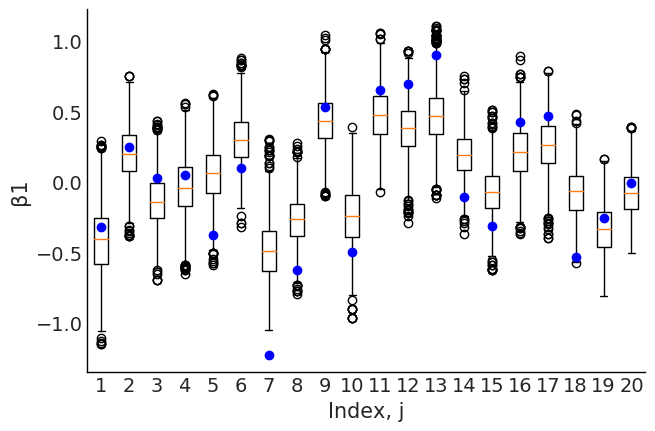

In [16]:
plt.boxplot(samples[:,:p])
plt.ylabel('β1')
plt.xlabel('Index, j')
plt.plot(range(1, 21), true_beta, 'bo');